# Домашнее задание 3

Выполнил: Тихонов Сергей, БЭК181

## Блок 1. Введение

В этом небольшом домашнем задании мы потренируемся работать с SARIMA-моделью. Для начала про данные. В этот раз они недельные. Будем прогнозировать на небольшой горизонт, 4 недели.

* target -- средневзвешенная по портам стоимость аммиака (usd/tonn) в некотором европейском регионе. Аммиак -- один из основных компонентов для производства азотных удобрений.
* oil -- стоимость фьючерса на нефть марки BRENT (usd)
* gas -- стоимость фьючерса на природный газ (usd)
* coal -- стоимость фьючерса на уголь (usd)
* corn, soybean, wheat, rice -- стоимость кукурузы, сои, пшеницы и риса соответственно (usd)

* usd_eur, usd_rub, usd_jpy, usd_cny -- курсы евро, рубля, йены и юаня к доллару
* usd_index -- индекс доллара

* cpy_us, cpi_china -- ВВП США и Китая


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm, chi2 
from statsmodels.tsa.seasonal import STL
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.ets import AutoETS

from sktime.forecasting.naive import NaiveForecaster
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.simplefilter(action="ignore")
plt.rcParams["figure.figsize"] = (23,9)

### 1.1) Загрузка данных. (0.5 балла)

Загрузите данные из файла data.csv. Сконвертируйте индексы в формат datetime. Обратите внимание на формат даты. При дефолтных параметрах конвертация произойдёт неверно. Далее используйте метод to_period, чтобы сконвертировать индексы, иначе ARIMA упадёт. В этот раз не будем разбивать на трейн и тест, а просто пройдёмся кросс-валидацией по всей выборке.



In [2]:
# Загрузка данных

data = pd.read_csv('data.csv')

data.index = data.date
#data.drop('date', axis=1, inplace=True)
data.head()

,date,target,oil,gas,coal,corn,soybean,wheat,rice,usd_eur,usd_jpy,usd_cny,usd_index,usd_rub,cpi_china,cpi_us
date,,,,,,,,,,,,,,,,
03/05/1987,03/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0
10/05/1987,10/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8559,139.73,3.7314,96.10,NaN,NaN,113.0
17/05/1987,17/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8501,139.58,3.7314,95.62,NaN,NaN,113.0
24/05/1987,24/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8513,140.83,3.7314,96.03,NaN,NaN,113.0
31/05/1987,31/05/1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8700,143.88,3.7314,97.89,NaN,NaN,113.0


In [3]:
# Удаление пропусков и конвертация индекса

target = data.target.dropna()
target.index = pd.to_datetime(target.index, format='%d/%m/%Y')
target = target.asfreq('W')

In [4]:
# Заполним пропуски предыдущим числом, поскольку если цены нет (а нет её обычно в нерабочие дни/нидели, поэтому берем последнее 
# доступное значение)

target.fillna(method='ffill', inplace=True)

### 1.2) Визуальный анализ. (1 балл)

Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

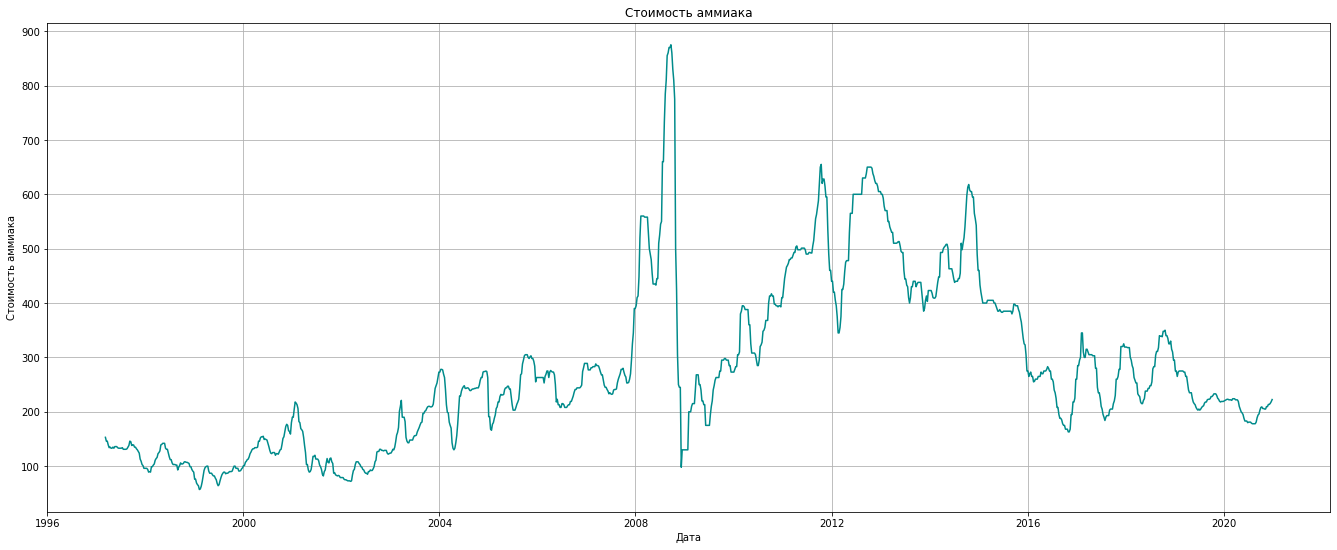

In [5]:
# График стоимости аммиака

plt.plot(target, color='darkcyan')
plt.title('Стоимость аммиака')
plt.xlabel('Дата')
plt.ylabel('Стоимость аммиака')
plt.grid(visible=1);

**Наблюдения по графику ряда** (без коррелограмм):

Структура ряда: 

* Структурных сдвигов в стандартном понимании нет, однако имеется "аномалии" в виде быстрого роста, который сменился резким падением в 2008 году.

Наличие тренда: 

* Можно сказать, что имеет место слабый линейный тренд с 1996 по 2012 (с поправкой на "аномалию" в 2008 году), после чего тренда нет.

Сезонность:

* В рамках года видны скачки, что говорит о наличии сезонности. Данный факт логичен, поскольку аммиак используется в качестве компонента для удобрения и, соответственно, используется при посевах. Период сезонности будет проверен ниже на коррелограммах.

Цикличность:

* Проверим ниже с помощью анализа остатков STL-разложения.

Стационарность:

* Более правильно будет проверить стационарность с помощью коррелограмм (выполнено ниже), однако подозревается нарушение предпосылки о постоянной дисперсии. По тренду стационарность ряда тоже нарушается. 


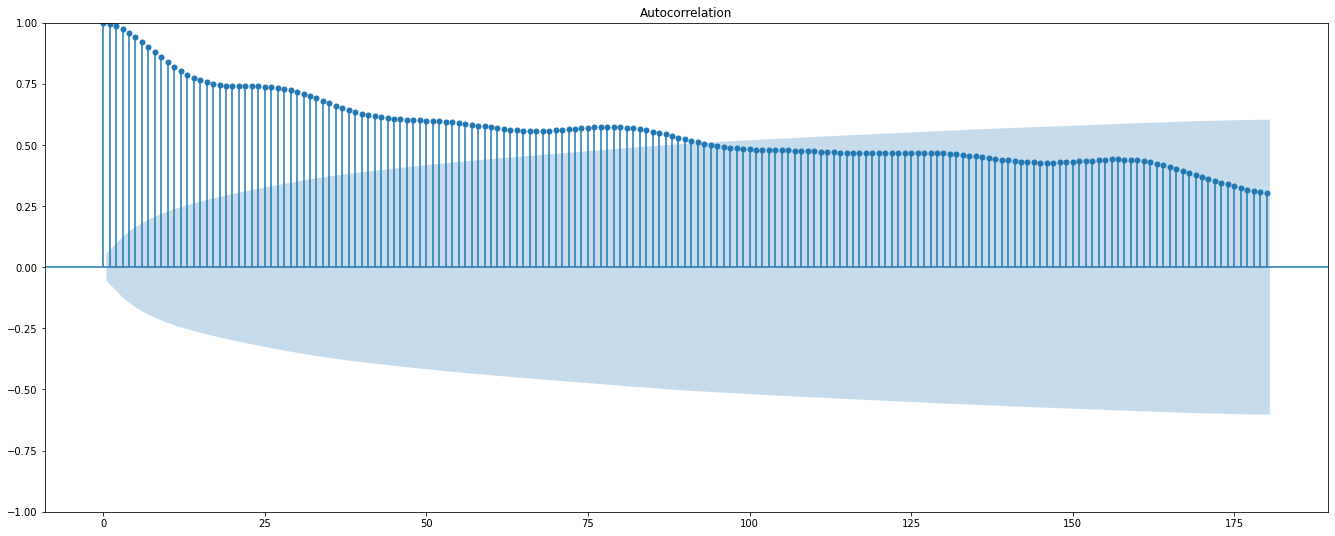

In [6]:
# ACF в уровнях

plot_acf(target, lags=180);

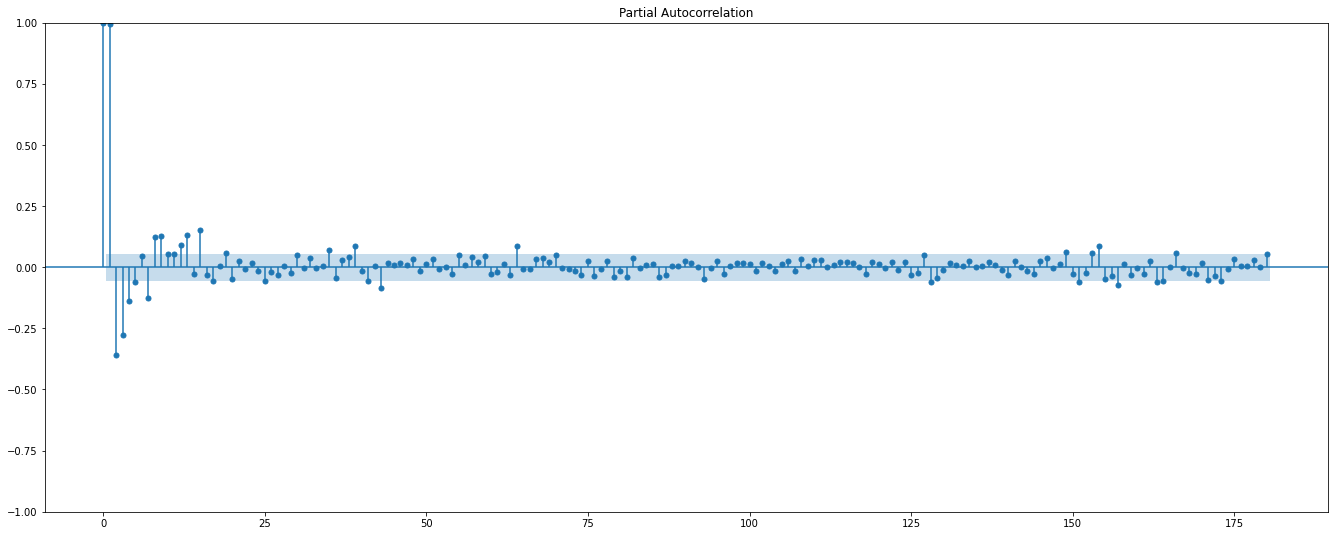

In [11]:
# PACF в уровнях

plot_pacf(target, lags=180, method="ols");

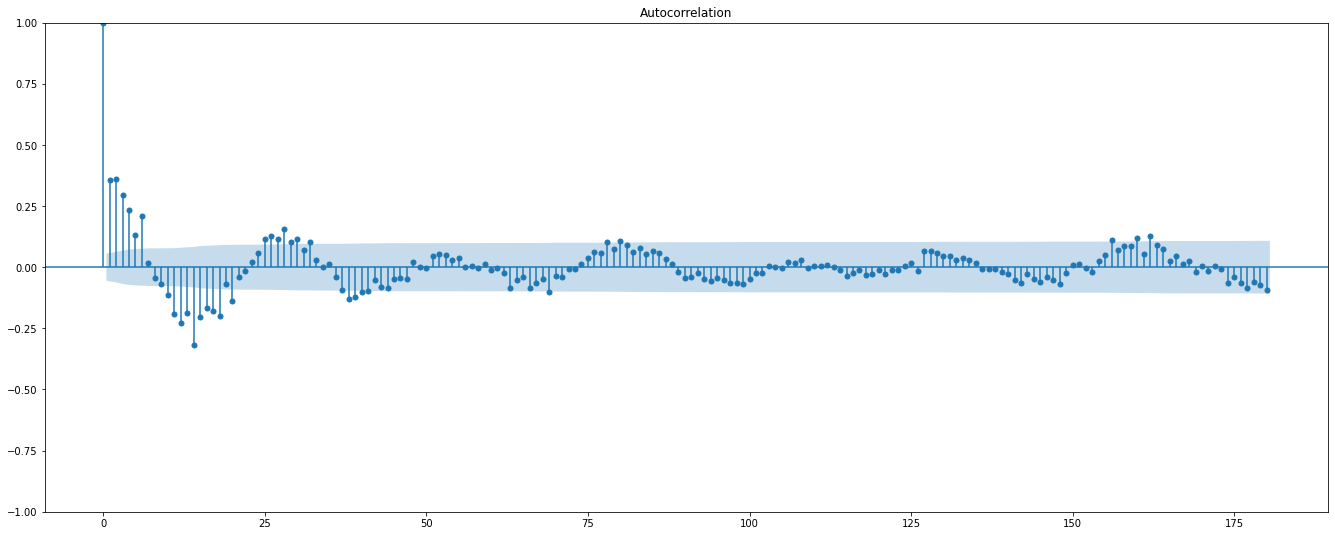

In [12]:
# ACF в первых разностях

plot_acf(target.diff().dropna(), lags=180);

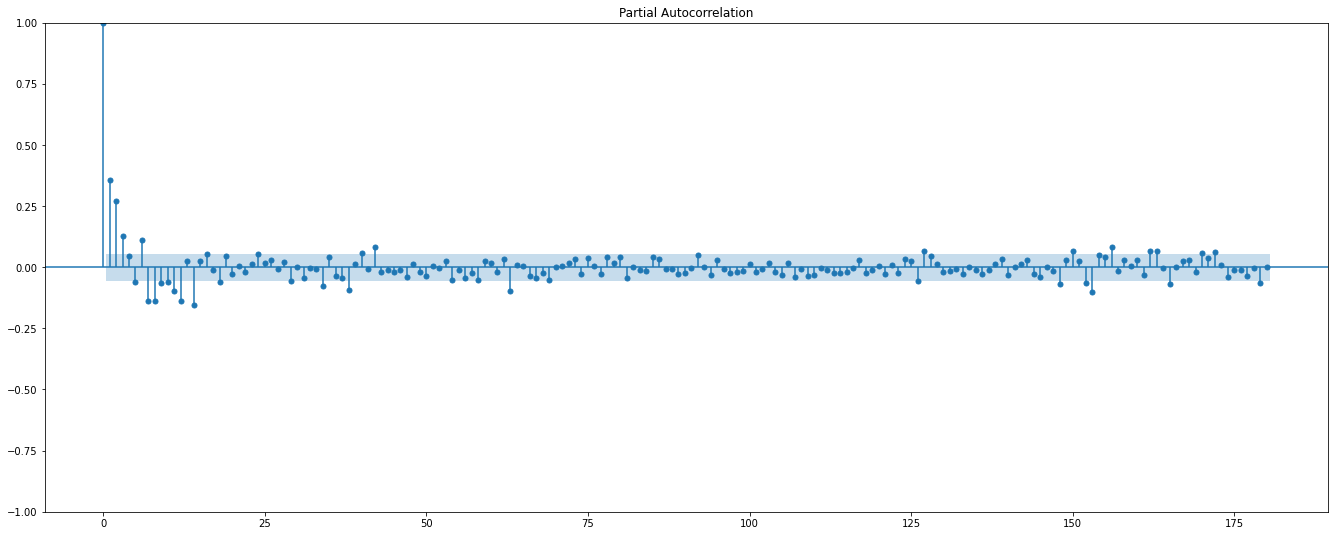

In [13]:
# PACF в первых разностях

plot_pacf(target.diff().dropna(), lags=180);

**Выводы по ACF/PACF**:

Сезонность

* Для определения сезонности посмотрим на значимость отдельных лагов. По графику ACF легко заметить, что значим каждый 12 лаг (и его окрестность), а значит имеет место трехмесячная сезонность. Аналогичные паттерны можно заметить на графике PACF.

Стационарность

* Автокорреляционная функция убывает **очень медленно**, причём лаги быстро перестают быть значимыми;

* Частная автокорреляционная функция имеет резкий обрыв после первого значимого лага, а многие следующие незначимы;

=> Это признаки нестационарного ряда. 

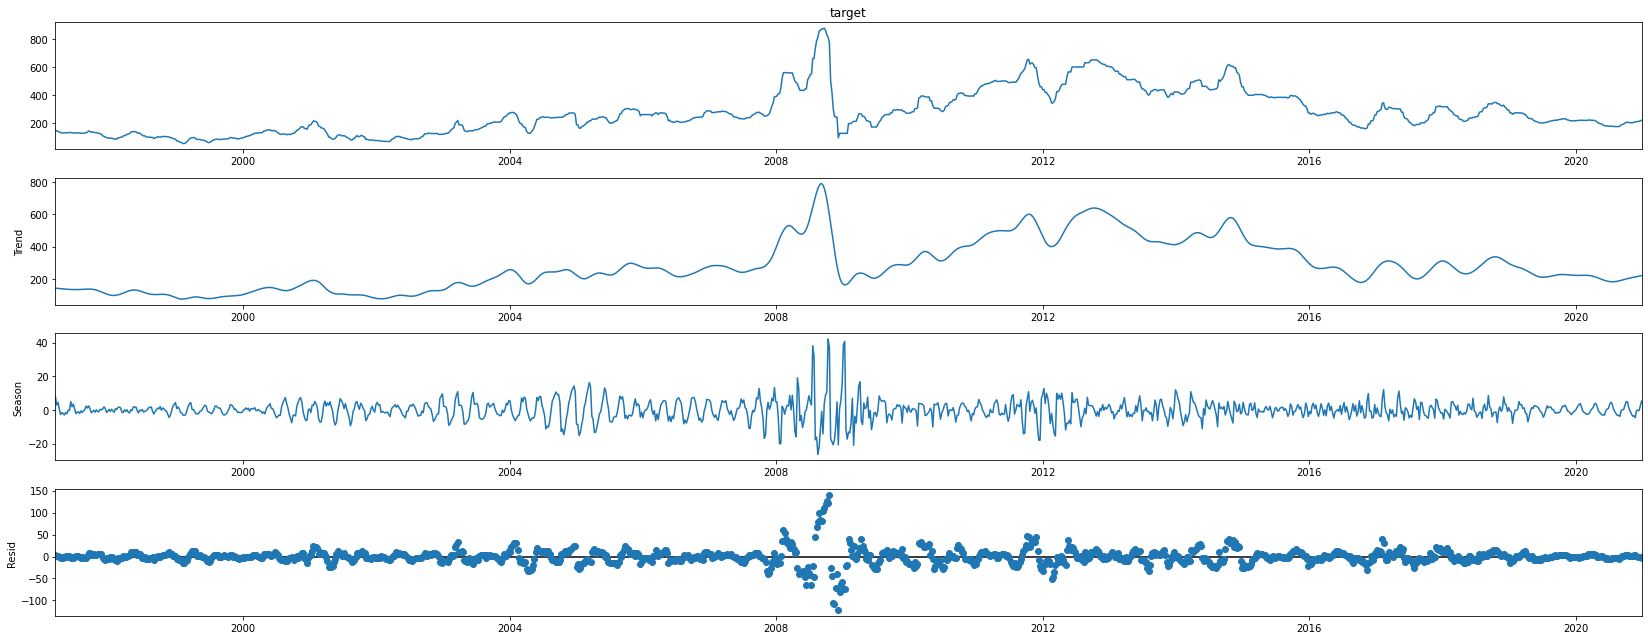

In [14]:
# STL декомпозиция

stl = STL(target, period=12)
res = stl.fit()

res.plot();

**Выводы по STL**:

Цикличность

* Легко заметить, что по графику остатков имеются циклы. Скорее всего, их природа является экономической и связана с колебаниями деловой активности в экономике.

## Блок 2. SARIMA

Сначала попробуем прогнозировать без внешних переменных.

### 2.1) Стационарность (1 балл)

Сначала примените сглаживающее преобразование (например, Бока-Кокса, или иное по своему усмотрению), если необходимо. 

Определите параметры d и D. Для этого воспользуйтесь STL-разложением и KPSS-тестом.

Детрендируйте ряд согласно параметрам d и D.

In [15]:
# Будем работать с логарифмом таргета

log_target = np.log(target)

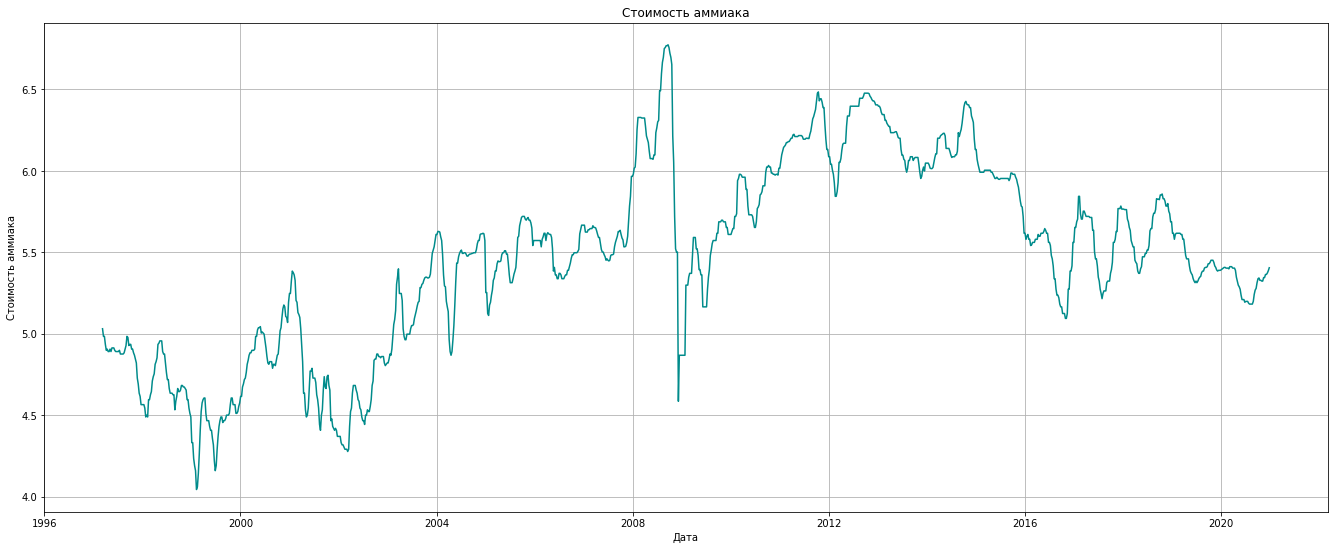

In [16]:
# График логарифма стоимости аммиака

plt.plot(log_target, color='darkcyan')
plt.title('Стоимость аммиака')
plt.xlabel('Дата')
plt.ylabel('Стоимость аммиака')
plt.grid(visible=1);

In [160]:
# parameter D 

seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))
seas_strength

0.09255795204012918

**Промежуточный вывод**:

Сила сезонности меньше 0.1 < 0.65, значит не будем переходить к сезонным разностям.


In [27]:
# parameter d

# В уровнях

kpss(log_target)

(3.1655343570995913,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [28]:
# В первых разностях

kpss(log_target.diff().dropna())

(0.04260618419250879,
 0.1,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**Промежуточный вывод**:

* В случае рассмотрения ряда в уровнях нулевая гипотеза о стационарности ряда отвергается.

* В случае рассмотрения ряда в первых разностях нулевая гипотеза о стационарности ряда не отвергается.

Значит, исходный ряд имеет порядок интегрирования I(1).

### 2.2) Анализ коррелограмм (1 балл)

Определите период сезонности, если она предполагается. Предположите, в каких границах лежат параметры p, q, P, Q. Для этого используйте коррелограммы.

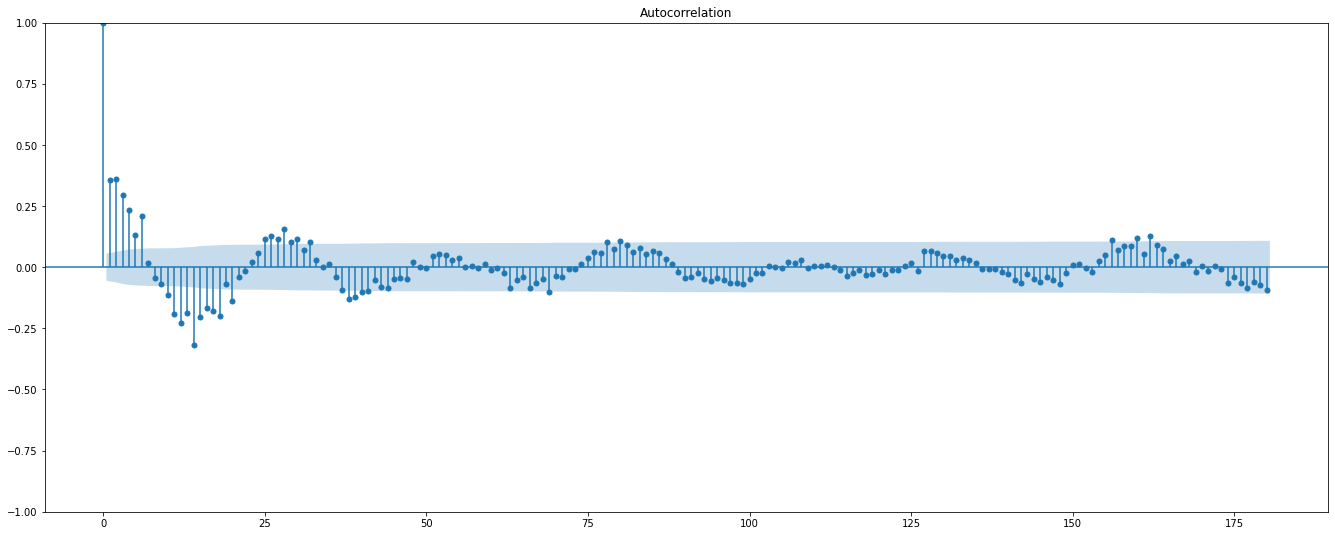

In [29]:
 # ACF в первых разностях

plot_acf(target.diff().dropna(), lags=180);

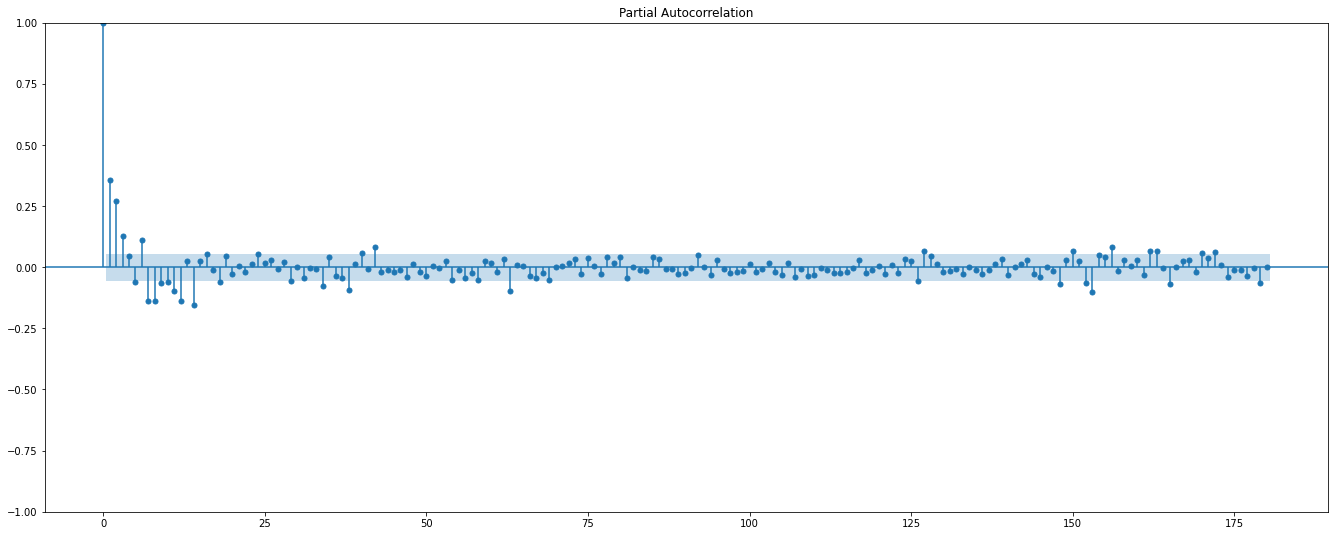

In [30]:
# PACF в первых разностях

plot_pacf(target.diff().dropna(), lags=180);

Период сезонности

* В первом разделе ДЗ с помощью коррелограмм был определен период сезонности 12 недель (3 месяца)

Параметры p, q, P, Q:
    
* Будем смотреть на коррелограммы и отслеживать количество значимых лагов. Для q видим, что имеется 4-6 значимых лагов в ACF, для p видим, что имеется 3 значимых лагах в PACF. Для q наблюдаем, что имеется 1 значимый сезонный лаг на ACF; для P наблюдаем, что имеется 1 значимый сезонных лаг на PACF.

**Комментарий от автора**: для кросс-валидации отбирал p,q **меньше**, чем показывает коррелограмма, поскольку очень долго ждать! Для каждой присваемой max_p, max_q после "#" писал, какое реальное количество значимых лагов имеет коррелограмма и, соответственно, сколько по-хорошему надо проверить кросс-валидацией.

In [31]:
# parameters p, q используя коррелограммы:

# ACF используется для поиска максимального q:

max_q = 3 # 4-6

# PACF используется для поиска максимального p:

max_p = 3 # 3

In [32]:
# parameters P, Q используя коррелограммы:

# ACF используется для поиска максимального Q:

max_Q = 1 # 3 

# PACF используется для поиска максимального P:

max_P = 1 # 1

### 2.3) Кросс-валидация (0.5 балла)

Сгенерируйте сетку параметров. Отберите на кросс-валидации наилучшую модель. Используйте метод скользящего окна. Ширина окна 150 (~3 года). Шаг -- 4 недели. Если получается слишком долго, возьмите шаг побольше, 10-15. Длина тестового периода -- 4 недели. Метрика -- MAE.

In [33]:
orders = []
seasonal_orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, 1, q))

for P in range(max_P+1):
    for Q in range(max_Q+1):
        seasonal_orders.append((P, 0, Q, 12))

fh = ForecastingHorizon(list(range(1, 5)))

In [34]:
cv = ExpandingWindowSplitter(
    start_with_window=True,
    initial_window=300,
    fh=fh,
    step_length=200)

forecaster = ARIMA()
param_grid = {"order" : orders,
             "seasonal_order" : seasonal_orders}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    scoring=MeanAbsoluteError(),
    param_grid=param_grid,
    cv=cv)
gscv.fit(log_target)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4], dtype='int64', is_relative=True),
            initial_window=None, step_length=200),
                        forecaster=ARIMA(),
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (0, 1, 3), (1, 1, 0), (1, 1, 1),
                                              (1, 1, 2), (1, 1, 3), (2, 1, 0),
                                              (2, 1, 1), (2, 1, 2), (2, 1, 3),
                                              (3, 1, 0), (3, 1, 1), (3, 1, 2),
                                              (3, 1, 3)],
                                    'seasonal_order': [(0, 0, 0, 12),
                                                       (0, 0, 1, 12),
                                                       (1, 0, 0, 12),
                                                       (1, 0, 1, 12)]},
                        scoring=MeanAbsoluteError

In [35]:
gscv.best_forecaster_

ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))

### 2.4 Сравнение (0.5 балла)

Сравните ошибку на кросс-валидации для вашей модели, наивной модели и AutoARIMA. Не забудьте проверить, что границы поиска параметров AutoARIMA не меньше ваших. Получилось ли переиграть две последние модели? Совпали ли отобранная вами модель и модель из AutoARIMA?


In [36]:
# CV

gscv.best_score_

0.02254808563574966

In [22]:
# Naive

fh = ForecastingHorizon(list(range(1, 5)))
cv = ExpandingWindowSplitter(
    start_with_window=True,
    initial_window=300,
    fh=fh,
    step_length=200)

forecaster = NaiveForecaster()
param_grid = {}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv, 
    scoring = MeanAbsoluteError(),
    n_jobs=-1)
gscv.fit(log_target)
gscv.best_score_

0.04240221522428032

In [23]:
# AutoARIMA

fh = ForecastingHorizon(list(range(1, 5)), is_relative=True)

forecaster_auto = AutoARIMA(sp=12, start_p=0, start_q=0, start_P=0, start_Q=0,
                            max_p=3, max_q=3, max_P=1, max_Q=1, d=1, D=0, stationary=True)


cv = ExpandingWindowSplitter(
    start_with_window=True,
    initial_window=300,
    fh=fh,
    step_length=200)

param_grid = {}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster_auto,
    scoring=MeanAbsoluteError(),
    param_grid=param_grid,
    cv=cv)
gscv.fit(log_target)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4], dtype='int64', is_relative=True),
            initial_window=None, step_length=200),
                        forecaster=AutoARIMA(D=0, d=1, max_P=1, max_Q=1,
                                             max_p=3, max_q=3, sp=12, start_P=0,
                                             start_Q=0, start_p=0, start_q=0,
                                             stationary=True),
                        param_grid={}, scoring=MeanAbsoluteError())

In [24]:
# CV AutoARIMA

gscv.best_score_

0.03553079211879737

In [25]:
# CV AutoARIMA

gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1243
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                1156.009
Date:                              Sat, 16 Apr 2022   AIC                          -2300.018
Time:                                      20:12:04   BIC                          -2269.266
Sample:                                           0   HQIC                         -2288.454
                                             - 1243                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.4120      0.009    158.742      0.000       1.395       1.429
ma.L2          1.1502      0.014     80.244      0.000       1.122       1.178
ma.L3          0.4895      0.010     46.840      0.000       0.469       0.510
ar.S.L12       0.9993      0.000   3491.695      0.000       0.999       1.000
ma.S.L12      -0.5890      0.016    -36.326      0.000      -0.621      -0.557
sigma2         0.0087      0.000     69.602      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                  84.80   Jarque-Bera (JB):             51976.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -2.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Выводы**:

1. Кросс валидации (с помощью выбора максимальных лагов используя коррелограммы) удалось обыграть AutoARIMA с теми же максимальными лагами. 

2. *Сами модели не совпали*: Кросс Валидация выбрала модель SARIMA(1,1,1)(1,0,1)[12], в то время как AutoARIMA выбрала SARIMA(0,1,3)(1,0,1)[12]. Различия легко объяснимо: CV смотрит на MAE, AutoARIMA смотрит на AIC (зависящий от количества параметра и максимума правдоподобия).

## Блок 3. SARIMAX

Маленькое вступление. Теперь мы попытаемся добавить в модель внешние регрессоры. Вообще говоря, модель SARIMAX -- это попытка объединить в одной модели всё сразу, что, ожидаемо, редко приводит к хорошему и устойчивому результату. И, что самое главное, такую модель ещё сложнее настраивать. Более эффективным с практической точки зрения было бы построить отдельно модель на внешних переменных (в духе моделей машинного обучения), а с автокорреляциями в её остатках побороться уже SARMA-моделью, но в случае линейной регрессии особой разницы не будет.  Но мы всё же разберём этот подход, чтобы понимать его сложности.

Если коротко про достоинства и недостатки этой модели:

Плюсы:

* Весьма гибкая модель, позволяет учесть кучу особенностей в данных
* Может быть неплоха, если нам нужны только одношаговые прогнозы и у нас не очень много переменных

Минусы:

* Ещё сложнее настраивать, чем SARIMA
* Рекурсивна. Отсюда проблемы с многошаговым прогнозированием и накоплением ошибки
* При большом количестве экзогенных переменных и малом числе наблюдений может быть неустойчива

### 3.1) Выбор внешней переменной (1 балл)

Из всех внешних факторов выберите какую-нибудь переменную, которая будет удовлетворять тесту Гранжера. Кратко опишите причинно-следственную связь, которая может возникать между этими переменными. 

По дефолту в следующих пунктах в качестве фичи можете использовать первый лаг отобранной переменной. Если захотите взять ещё лаги, это конечно хорошо, но придётся аккуратно разбираться с прогнозом каждого лага, поэтому предлагается не усложнять себе жизнь.

In [53]:
log_target = np.log(target)
log_target = pd.DataFrame({'target': log_target, 'date': log_target.index})
log_target = log_target.reset_index(drop=True)

In [54]:
data = pd.read_csv('data.csv')
data.date = pd.to_datetime(data.date, format='%d/%m/%Y')
data.index = data.date

In [55]:
log_target = pd.merge(log_target, data.usd_index, how='left', on='date').shift().dropna()
log_target.index = log_target.date
log_target.drop('date', axis=1, inplace=True)

log_target = log_target.asfreq('W')

In [57]:
_ = grangercausalitytests(log_target, maxlag = [10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8713  , p=0.0015  , df_denom=1211, df_num=10
ssr based chi2 test:   chi2=29.2111 , p=0.0012  , df=10
likelihood ratio test: chi2=28.8701 , p=0.0013  , df=10
parameter F test:         F=2.8713  , p=0.0015  , df_denom=1211, df_num=10


**Вывод по тесту Грейнджера**: Гипотеза о том, что временной ряд из второй колонки (Индекс потребительских цен в США) НЕ помогает в прогнозировании первой колонки (цены на аммиак) **отвергается** при любом уровне значимости. Значит, индекс потребительских цен в США помогает улучшить прогноз цен на аммиак.

Здесь имеется двунаправленная причинно-следственная связь.

С одной стороны, поскольку аммиак можно рассматриваться в качестве "издержек" для производства сельскохозяйственной продукции, то рост цен на аммиак может приводить к росту цен на продукты, которые включаются в индекс CPI.

С другой стороны, если в экономике повышается инфляция, то цены на аммиак тоже возрастуют из-за так называемых инфляционных спиралей: опасаясь высокой инфляции потребители не хранят деньги, а тратят их. Производство не успевает приспособиться, рост цен ускоряется. 

В данном контексте, нам более интересен **второй** эффект.

### 3.2) Фильтрация (1.5 балла)

Использование внешней переменной несколько осложняет подбор параметров SARIMA. Дело в том, что если ряды y и x одинакового порядка интеграции, то при использовании их в одном уравнении тренды могут взаимно сократиться:

$$ y_t = SARIMA + \alpha_1 x_{t-1}$$

$$ y_t - \alpha_1 x_{t-1} = SARIMA $$

При некоторых обстоятельствах разница  $ y_t - \alpha_1 x_{t-1} $ может дать стациионарный ряд. В литературе такая ситуация называется коинтеграцией. Есть много не слишком внятных статей на эту тематику. Особенно туманны выводы для случаев, когда коинтеграции нет. Но в целом всё это скорее разговор о теоретических характеристиках оценок коэффициентов моделей. В контексте прогнозирования это обычно не учитывают и каких-то внятных рекомендаций тоже нет, либо они не распространены. Поэтому единственный адекватный способ узнать это влияние -- построить регрессию (либо SARIMA((0,0,0), (0,0,0)) с экзогенной переменной), а потом посмотреть, как устроены остатки, и на основе них сделать выводы о параметрах SARIMA. 

В большинстве случаев люди, конечно, так не заморачиваются. Берут AutoARIMA либо достаточно широкие границы на кросс-валидации и просто ждут. Но мы же учёные, нам так неинтересно!

Здесь уже видно, что в таком виде SARIMAX-модель банально аналогична тому, что мы оцениваем две модели: линрег, а на его остатки навешиваем SARIMA. Единственный плюс в том, что мы сможем это объединить в одном уравнении.


Собственно, задание: постройте SARIMAX((0,0,0), (0,0,0))  с выбранной экзогенной переменной (либо просто линрег y_t на x_{t-1}, будет то же самое). Будьте внимательны, дефолтный параметры класса ARIMA -- не совсем то, что мы просим. Далее получите остатки на трейне этой одношаговой модели.

In [58]:
y = log_target.target
X = log_target.usd_index

# По сути, линейная регрессия:
forecaster =  ARIMA(
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    suppress_warnings=True)

forecaster.fit(y, X)

ARIMA(order=(0, 0, 0), suppress_warnings=True)

In [60]:
resid = forecaster.predict_residuals(y, X)

### 3.3) Анализ остатков (1 балл)

Остатки из предыдущего пункта -- это по сути y, фильтрованный относительно выбранной экзогенной переменной. Сделайте выводы относительно параметров d и D, а также относительно границ параметров p, q, P, Q.

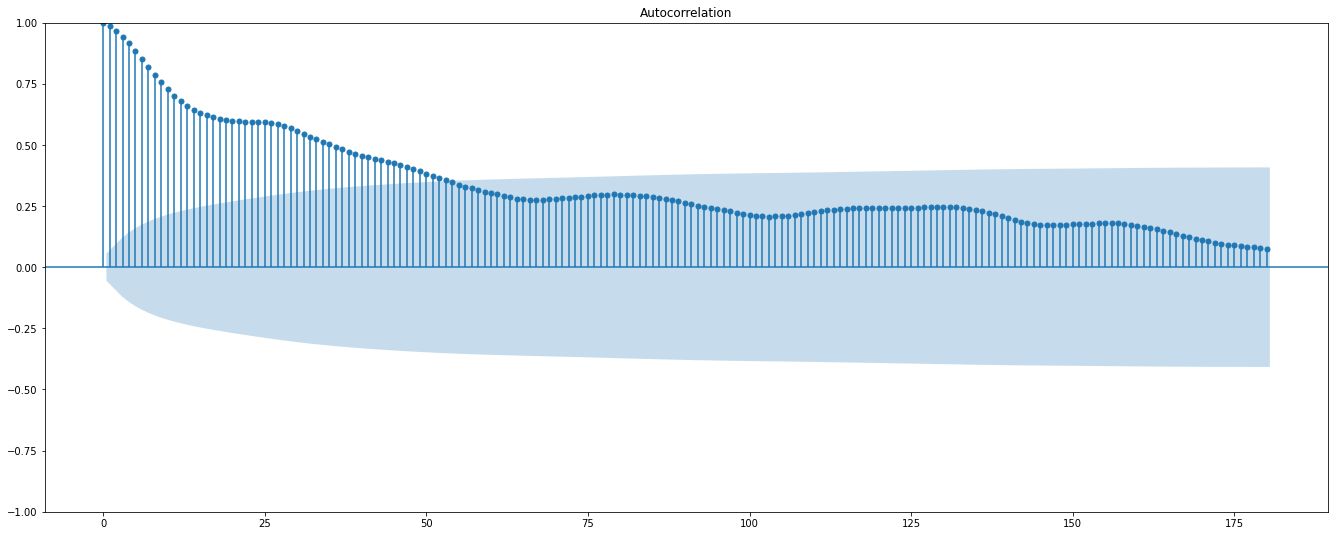

In [61]:
 # ACF остатков

plot_acf(resid, lags=180);

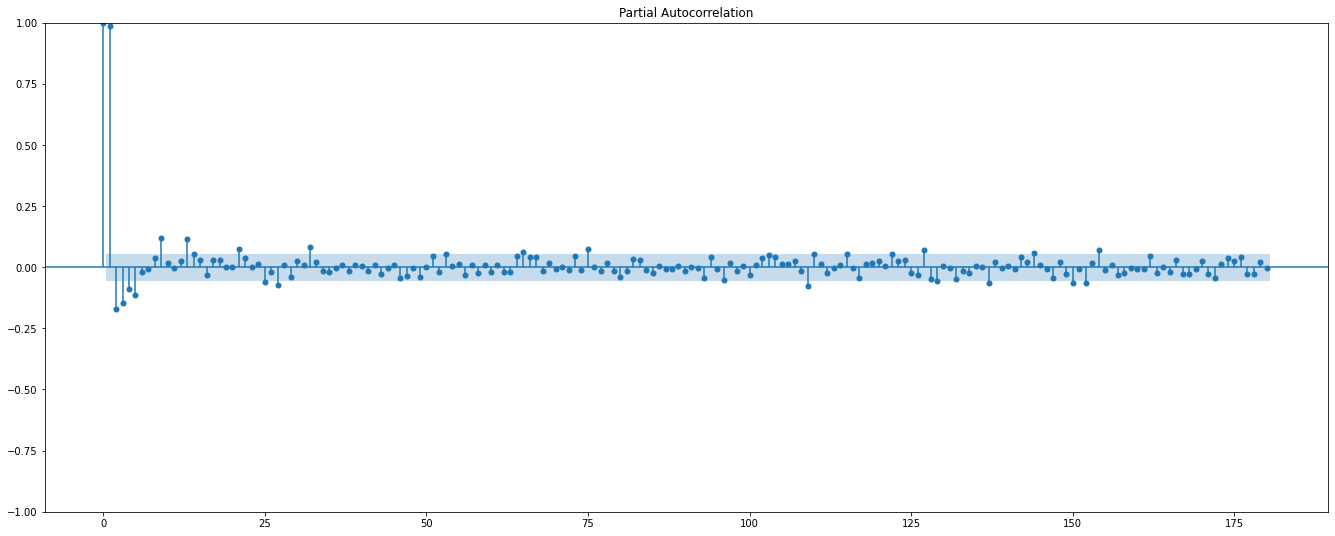

In [62]:
# PACF остатков

plot_pacf(resid, lags=180);

**Промежуточный вывод**: ACF медленно убывает, PACF обрывается после первого лага - признаки нестационарного ряда остатков. 

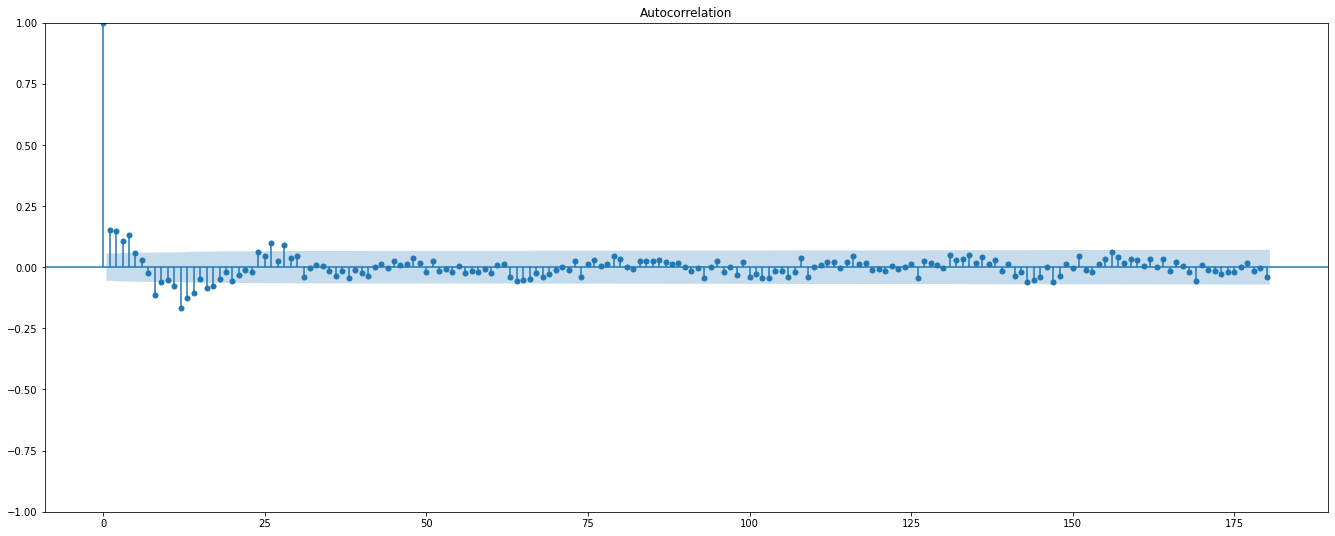

In [63]:
 # ACF разностей остатков

plot_acf(resid.diff().dropna(), lags=180);

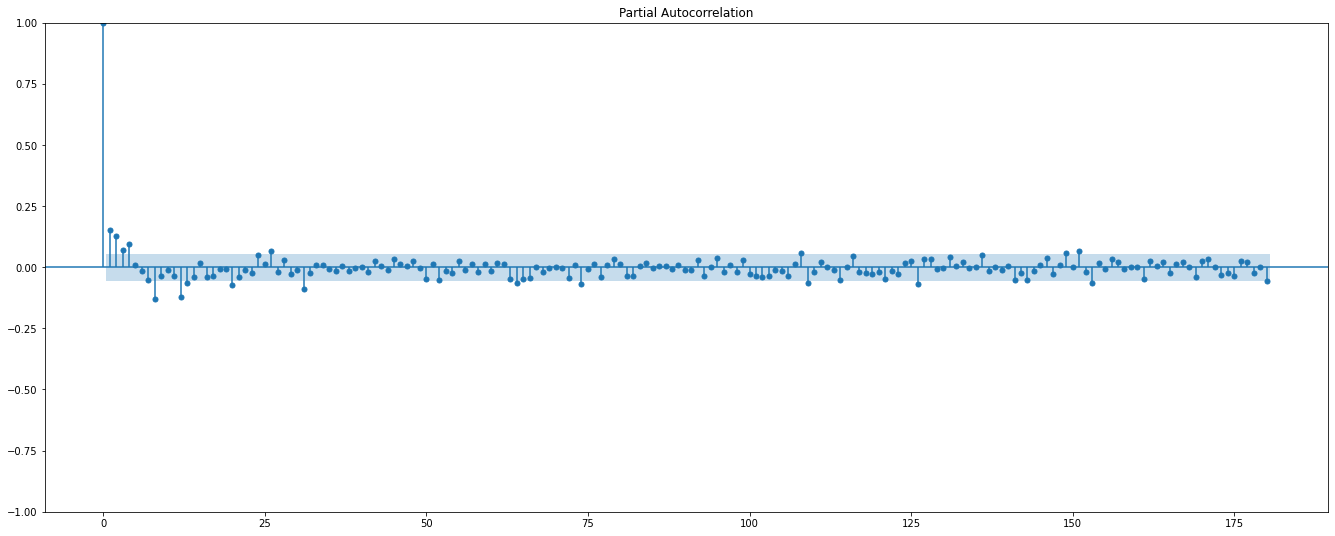

In [64]:
# PACF разностей остатков

plot_pacf(resid.diff().dropna(), lags=180);

**Комментарий от автора**: для кросс-валидации отбирал p,q **меньше**, чем показывает коррелограмма, поскольку очень долго ждать! Для каждой присваемой max_p, max_q после "#" писал, какое реальное количество значимых лагов имеет коррелограмма и, соответственно, сколько по-хорошему надо проверить кросс-валидацией.

In [158]:
# parameters p, q используя коррелограммы:

# ACF используется для поиска максимального q:

max_q = 3 # 4-6

# PACF используется для поиска максимального p:

max_p = 3 # 3


# parameters P, Q используя коррелограммы:

# ACF используется для поиска максимального Q:

max_Q = 1 # 1 

# PACF используется для поиска максимального P:

max_P = 1 # 1

Аналогично, проведём выбор параметров d и D через STL разложение (для определения силы сезонности) и через KPSS тест:

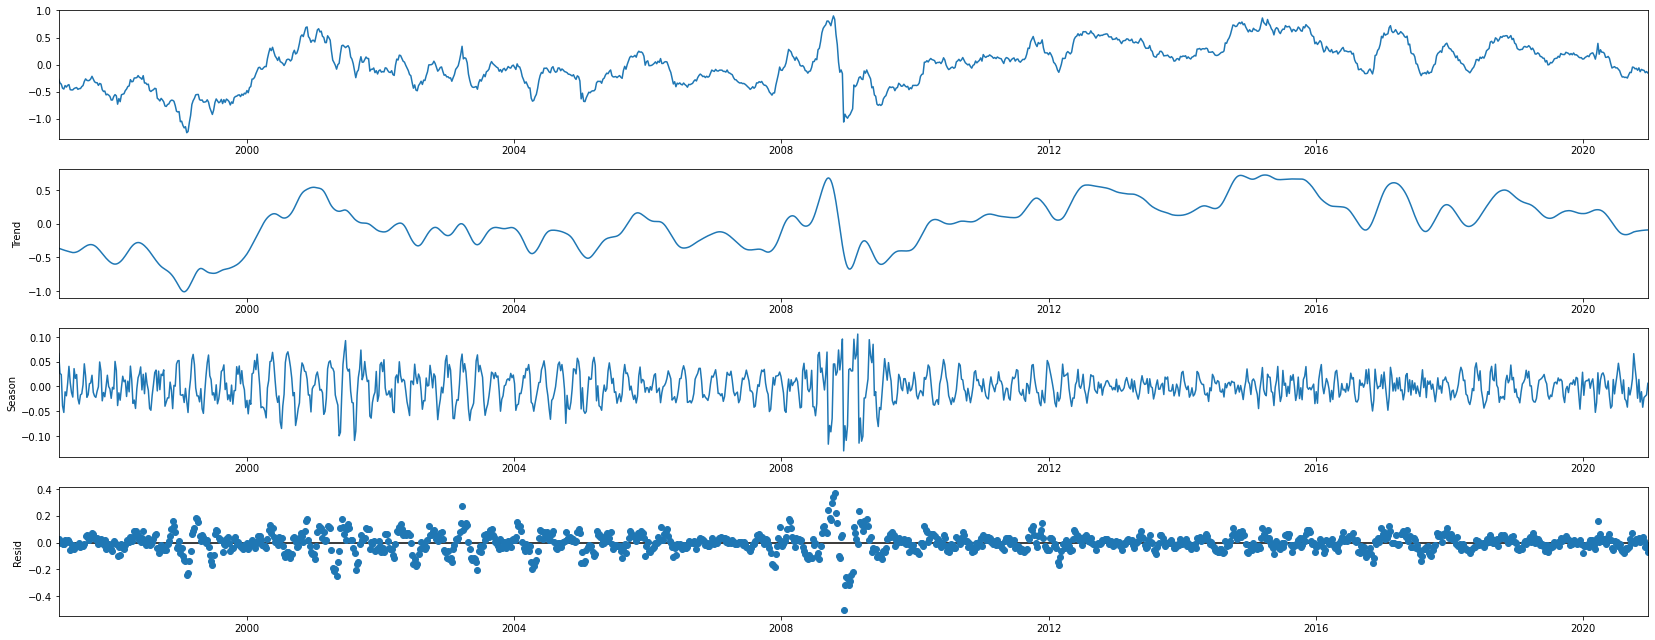

In [65]:
# STL декомпозиция

stl = STL(resid, period=12)
res = stl.fit()

res.plot();

In [66]:
# parameter D 

seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))
seas_strength

0.15617662262704868

**Промежуточный вывод**: интенсивность сезонности низкая, а значит сезонные разности не требуются.

In [67]:
# parameter d

# В уровнях

kpss(resid)

(2.447861805947724,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [68]:
# В первых разностях

kpss(resid.diff().dropna())

(0.020347579634216777,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**Промежуточный вывод**: гипотеза о стационарности остатков в уровнях отвергается, а гипотеза о стационарности остатков в первых разностях не отвергается.

### 3.4) Кросс-валидация (1.5 балла)

Отберите на кросс-валидации наилучшую модель. Для прогноза фичи на необходимые 4 шага используйте AutoARIMA. 



In [122]:
def candidate_test(X, y, order, seasonal_order):
    
    mae = []
    fh = ForecastingHorizon(list(range(1, 5)))
    cv = ExpandingWindowSplitter(
        start_with_window=True,
        initial_window=300,
        fh=fh,
        step_length=200)

    for train_indexes, test_indexes in cv._split_windows(start=300, end=1242, step_length=200, 
                                                         window_length=300, y=y, fh=4):
        
        X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
        y_test = y.iloc[np.arange(test_indexes-3, test_indexes+1)]
        
        forecaster =  ARIMA(order=order, seasonal_order=seasonal_order, sp=12)
        forecaster.fit(y_train, X_train)

        forecaster_X = AutoARIMA(sp=12, suppress_warnings=True)
        forecaster_X.fit(X_train)

        X_pred = forecaster_X.predict(fh)
        pred = forecaster.predict(fh, X_pred)

        mae.append(mean_absolute_error(y_test, pred))
    
    return np.mean(mae)  

In [123]:
def aggregate(X, y):
    
    mae_all = []
    
    orders = []
    seasonal_orders = []

    for p in range(max_p+1):
        for q in range(max_q+1):
            orders.append((p, 1, q))

    for P in range(max_P+1):
        for Q in range(max_Q+1):
            seasonal_orders.append((P, 0, Q, 12))
            
    for order in orders:
        for seasonal_order in seasonal_orders:
            
            mae_all.append(candidate_test(X, y, order, seasonal_order))
    
    return mae_all

In [124]:
mae = aggregate(X, y)

In [144]:
table = np.array(mae).reshape(len(orders), len(seasonal_orders))
maes = pd.DataFrame(table, index=orders, columns=seasonal_orders)
maes

,"(0, 0, 0, 12)","(0, 0, 1, 12)","(1, 0, 0, 12)","(1, 0, 1, 12)"
"(0, 1, 0)",0.041868,0.036078,0.035642,0.035477
"(0, 1, 1)",0.038120,0.034637,0.034245,0.033860
"(0, 1, 2)",0.034853,0.032558,0.031883,0.030994
"(1, 1, 0)",0.034216,0.032622,0.032130,0.031407
"(1, 1, 1)",0.028916,0.033070,0.031290,0.025613
"(1, 1, 2)",0.025846,0.027624,0.027152,0.025534
"(2, 1, 0)",0.029876,0.031042,0.030524,0.028421
"(2, 1, 1)",0.026285,0.028636,0.027370,0.025067
"(2, 1, 2)",0.023314,0.024881,0.024264,0.022373
"(3, 1, 0)",0.025986,0.027827,0.027193,0.025118


Легко заметить, что минимальная ошибка получилась на пересечении **(2,1,2)** и **(1,0,1,12)** (подтвердим это ниже):

In [157]:
np.min(table)

0.022373155332235405

В результате, получаем, что оптимальная модель является SARIMAX(2,1,2)(1,0,1)[12] (с регрессором "Инфляция в США"). 

### 3.5) Сравнение результатов (0.5 балла)

Добавьте к сравнению из пункта 2.4 лучшую модель из пункта 3.4. Получилось ли лучше?

**Вывод**: MAE у SARIMAX (0.02237) оказалось **ниже**, чем у простой SARIMA (0.02254) - хоть и незначительно. Такой результат ожидаем, поскольку учёт дополнительного регрессора может позволить объяснить поведение остатков. Данный факт был подтвержден с помощью теста Грейнджера, вывод которого следующий: инфляция в США позволяет улучшить прогноз цен на аммиак.

## Скиньте мем (Бесценно)

Можно скидывать прямо в энитаск, в ноутбуках не всегда прикрепляются =(

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"
Поделитесь, что вам понравилось, а что нет. Это важно